## SVM Checker

In [1]:
import numpy as np
import logging

In [2]:
import cvxopt.solvers

In [3]:
import math

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools


In [7]:
class Kernel:
    """Check kernels here https://en.wikipedia.org/wiki/Support_vector_machine"""
    @staticmethod
    def linear():
        return lambda x, y: np.inner(x, y)

    @staticmethod
    def gaussian(sigma):
        gamma = 1/(2*sigma**2)
        return lambda x, y: math.exp(-gamma*(np.linalg.norm(x-y))**2)

In [14]:
k = Kernel()
k.gaussian(1)(1, 0)

0.6065306597126334

In [5]:
MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5

In [16]:
x = np.array([[1, 2, 3]])
cvxopt.matrix(np.outer(x, x))


<3x3 matrix, tc='i'>

In [20]:
MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5


class SVMTrainer:
    def __init__(self, kernel, c=0.1):
        self._kernel = kernel
        self._c = c


    def train(self, X, y):
        """
            X: martix of features
            y: vector of labels

            next step: Compute lagrange multipliers by calling _compute_lagrange_multipliers method
            retrun:    Return Predictor object by calling _create_predictor method
        """
        lagrange_multipliers = self._compute_lagrange_multipliers(X, y)
        return self._create_predictor(X, y, lagrange_multipliers)


    def _kernel_matrix(self, X):
        """
            X: martix of features

            next step: Get number of samples
            next step: Create zero matrix of quadratic shape of number of samples 
            next step: Calculate kernels
            retrun:    Return Kernels matrix
        """
        n_samples = X.shape[0]

        K = np.zeros((n_samples, n_samples))

        print(X)

        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)

        return K


    def _create_predictor(self, X, y, lagrange_multipliers):
        """
            X: martix of features
            y: vector of labels
            lagrange_multipliers: vector of langrange multipliers

            next step: Get non-zero lagrange multipliers indicies
            next step: Get non-zero lagrange multipliers
            next step: Get support vecorts
            next step: Get support vecort labels
            next step: Сompute bias (use avg trick)
            retrun   : Return SVMPredictor object
        """

        support_vector_indices = lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER

        support_multipliers = lagrange_multipliers[support_vector_indices]

        support_vectors = X[support_vector_indices]

        support_vector_labels = y[support_vector_indices]

        bias = np.mean(
            [y_k - SVMPredictor(
                    kernel=self._kernel,
                    bias=0.0,
                    weights=support_multipliers,
                    support_vectors=support_vectors,
                    support_vector_labels=support_vector_labels
                ).predict(x_k) for (y_k, x_k) in zip(support_vector_labels, support_vectors)
            ]
        )

        return SVMPredictor(
            kernel=self._kernel,
            bias=0.0,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels
        )


    def _compute_lagrange_multipliers(self, X, y):
        """
            X: martix of features
            y: vector of labels


            Need to Solve
                min 1/2 x^T P x + q^T x (aplha is x)
                s.t.
                    Gx <= h (alpha >= 0)
                    Ax = b (y^T * alpha = 0)


            next step: Get number of samples
            next step: Create Kernel matrix by calling _kernel_matrix method
            next step: Create create quadratic term P based on Kernel matrix
            next step: Create linear term q
            next step: Create G, h, A, b
            next step: Solve with - cvxopt.solvers.qp(P, q, G, h, A, b)
            retrun:    Return flatten solution['x']
        """


        n_samples = X.shape[0]

        K = self._kernel_matrix(X)

        P = cvxopt.matrix(np.outer(y, y) * K)

        q = cvxopt.matrix(-1 * np.ones(n_samples))

        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))

        h = cvxopt.matrix(np.zeros(n_samples))

        A = cvxopt.matrix(y, (1, n_samples))

        b = cvxopt.matrix(0.0)


        # Check this

        # -a_i \leq 0
        # G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        # h_std = cvxopt.matrix(np.zeros(n_samples))

        # # a_i \leq c
        # G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        # h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)

        # G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        # h = cvxopt.matrix(np.vstack((h_std, h_slack)))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        return np.ravel(solution['x'])


class SVMPredictor(object):
    def __init__(
                self,
                kernel,
                bias,
                weights,
                support_vectors,
                support_vector_labels
            ):
        
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels


        assert len(support_vectors) == len(support_vector_labels)
        assert len(weights) == len(support_vector_labels)


        logging.info("Bias: %s", self._bias)
        logging.info("Weights: %s", self._weights)
        logging.info("Support vectors: %s", self._support_vectors)
        logging.info("Support vector labels: %s", self._support_vector_labels)

    def predict(self, x):
        """
        Computes the SVM prediction on the given features x.
        """
        result = self._bias
        for w_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += w_i * y_i * self._kernel(x_i, x)

        return np.sign(result).item()


In [31]:
%matplotlib inline
import svm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools




def example(num_samples=10, num_features=2, grid_size=500):
    
    samples = np.matrix(np.random.normal(size=num_samples * num_features)
                        .reshape(num_samples, num_features))
    
    labels = 2 * (samples.sum(axis=1) > 0) - 1.0
    
    trainer = svm.SVMTrainer(svm.Kernel.linear())
    print(trainer._kernel_matrix(samples).shape)
    predictor = trainer.train(samples, labels)

    plot(predictor, samples, labels, grid_size)


def plot(predictor, X, y, grid_size):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
        indexing='ij'
    )
    
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []
    
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
        result.append(predictor.predict(point))

    Z = np.array(result).reshape(xx.shape)
    
    plt.contourf(
        xx, yy, Z,
        cmap=cm.Paired,
        levels=[-0.01, 0.01],
        extend='both',
        alpha=0.8
    )
    
    
    plt.scatter(
        flatten(X[:, 0]),
        flatten(X[:, 1]),
        c=flatten(y),
        cmap=cm.Paired
    )
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

[[ 1.15947784  1.12776845]
 [ 0.44961451 -0.53339564]
 [ 0.91100516 -1.00871078]
 [ 0.93014191 -0.11386352]
 [-2.52753139 -0.51489152]
 [-0.90650316  0.67771234]
 [ 0.6509031  -0.26659312]
 [-1.36467578  0.19076284]
 [-0.48556435 -0.59596027]
 [-0.37170428  1.03260993]]
(10, 10)
[[ 1.15947784  1.12776845]
 [ 0.44961451 -0.53339564]
 [ 0.91100516 -1.00871078]
 [ 0.93014191 -0.11386352]
 [-2.52753139 -0.51489152]
 [-0.90650316  0.67771234]
 [ 0.6509031  -0.26659312]
 [-1.36467578  0.19076284]
 [-0.48556435 -0.59596027]
 [-0.37170428  1.03260993]]
     pcost       dcost       gap    pres   dres
 0: -4.6829e+00 -1.0254e+01  3e+01  5e+00  2e+00
 1: -1.2637e+01 -1.2972e+01  7e+00  2e+00  6e-01
 2: -1.8842e+01 -2.1596e+01  1e+01  9e-01  4e-01
 3: -1.8309e+01 -1.8889e+01  2e+00  1e-01  4e-02
 4: -1.8029e+01 -1.8039e+01  2e-02  1e-03  4e-04
 5: -1.8028e+01 -1.8028e+01  2e-04  1e-05  4e-06
 6: -1.8028e+01 -1.8028e+01  2e-06  1e-07  4e-08
Optimal solution found.


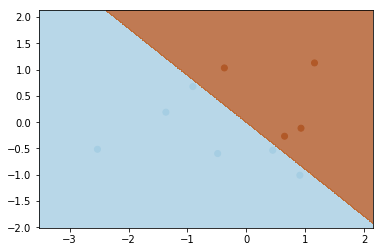

In [32]:
example()